# COSC 6373 - HW5-ICA - Minh Nguyen #2069407

In [1]:
# !pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, ops

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Define dataset paths
train_dir = "train"
test_dir = "test"

# Define parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

input_shape = IMG_SIZE + (3,)
print(f"Input shape: {input_shape}")

num_classes = 2

# Load training and validation data
# where the validation data is extracted with 20 images from each class in the training data

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=(20/180),
    subset="training",
    seed=42
)

val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=(20/180),
    subset="validation",
    seed=42
)

# Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Input shape: (256, 256, 3)
Found 360 files belonging to 2 classes.
Using 320 files for training.
Found 360 files belonging to 2 classes.
Using 40 files for validation.
Found 40 files belonging to 2 classes.


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
# batch_size = BATCH_SIZE
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
# image_size = 128  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_data.map(lambda x, y: x))
# data_augmentation.layers[0].adapt(x_train)

2025-04-14 22:39:17.844967: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


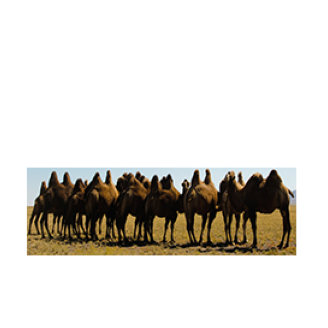

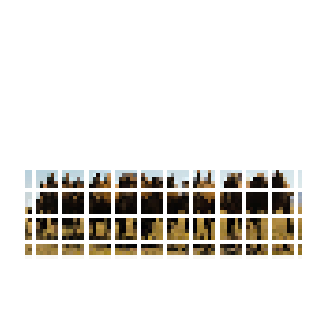

In [9]:
plt.figure(figsize=(4, 4))
image = next(iter(train_data.map(lambda x, y: x).take(1))).numpy()[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [10]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_data,
        validation_data=val_data,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    _, accuracy, top_5_accuracy = model.evaluate(test_data)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5232 - loss: 2.7709 - val_accuracy: 0.4250 - val_loss: 2.6039
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4864 - loss: 1.9902 - val_accuracy: 0.4750 - val_loss: 2.2183
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5101 - loss: 1.0664 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 973ms/step - accuracy: 0.5655 - loss: 0.8061 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - accuracy: 0.5202 - loss: 0.7429 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4996 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 822ms/step - accuracy: 0.5087 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 794ms/step - accuracy: 0.5480 - loss: 0.6931 - val_accuracy: 0.5750 - 

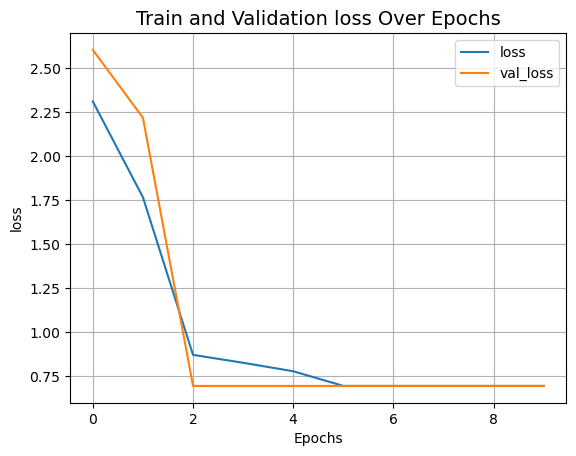

In [12]:
import time


vit_classifier = create_vit_classifier()
# print(vit_classifier.summary())
# vit_classifier.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )
vit_classifier.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)


start_time = time.time()
# run the experiment
# history = run_experiment(vit_classifier)

# train the model
history = vit_classifier.fit(
    train_data,
    validation_data=val_data,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
)

end_time = time.time()
training_time = end_time - start_time
print(f"Experiment time: {training_time:.2f} seconds")


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
# plot_history("top-5-accuracy")

- It takes around 2 mins to train the model.

In [13]:
# Evaluate the model on test data 
test_loss, test_acc = vit_classifier.evaluate(test_data)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4583 - loss: 0.6931
Test accuracy: 0.5000
Test loss: 0.6931


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


2025-04-14 22:41:06.818566: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


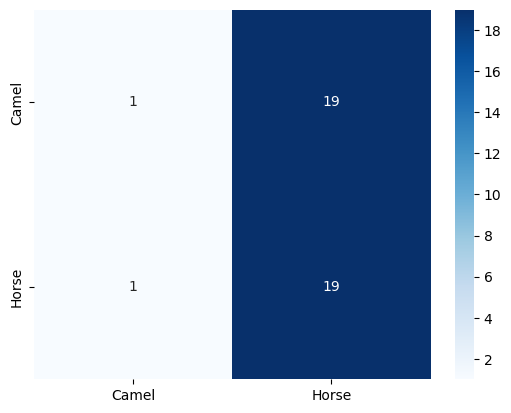

In [14]:
# Generate confusion matrix
y_pred = vit_classifier.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_data], axis=0)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', xticklabels=['Camel', 'Horse'], yticklabels=['Camel', 'Horse'])
plt.show()

### Comments:
5. Compared to the CNN that we evaluated on the same dataset in HW07, the CNN model performed better. I think the main reason is because the CNN model is actually based on ResNet50, which is a very well pre-trained model. It was pre-trained on a very large dataset, therefore, with a bit of fine-tuning, it can achieve a very good performance on the new dataset. The CNN model is also more complex than the MLP model, which allows it to learn more complex features from the data. The MLP model is a simple feed-forward neural network, which is not as powerful as the CNN model. Therefore, the CNN model is able to achieve a better performance on the same dataset.

6. For the Vision Transformer to outperform the state-of-the-art CNNs, I think it needs to be pre-trained on a large enough, high-resolution dataset. It is a very powerful model, but it requires a lot of data to learn the features effectively. If the dataset is too small or not diverse enough, the Vision Transformer may not be able to learn the features effectively and may not perform as well as the CNN model. Also, the Vision Transformer may require more computational resources to train compared to the CNN model, which may also affect its performance on smaller datasets.